## The MNIST digits dataset

### Tasks. Part 1. Unsupervised Learning: Dimensionality Reduction on Digits

We'd like to visualize our points within the 64-dimensional parameter space, but it's difficult to plot points in $N=64$ dimensions! So we need to reduce the dimensionality of the space


3) Use the unsupervised dimensionality reduction technique called **[`Isomap`](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html#sklearn.manifold.Isomap)**. Isomap is an embedding tecnique, which tries to understand if your $N$ dimensional datapoint live in a $N$ dimensional (with $N<M$) manyfold. Have a look at the Isomap documentation and reduce the MINST dataset.  Do some plots to visualize your results 

*Note*. Isomap is very recent. It was introduced by [Tenenbaum et al (2000)](https://www.science.org/doi/10.1126/science.290.5500.2319) ---a paper that has something like $1.5\times 10^4$ [citations](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=a+global+geometric+framework+for+nonlinear+dimensionality+reduction&btnG=).


### Tasks. Part 2. Supervised Learning: Classification on Digits

Now we want to classify the dataset. 

4) Split the dataset taking 80% of the images as tranining dataset and leaving the other 20% as a validation set. You need `sklearn.model_selection.train_test_split`.

5) Use a simple [`Logistic Regression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) which despite its name is a common classification algorithm. (I know, this is confusing!). Use the flag `solver='sag'` (I found the default solver had a bug, at least when I tried).

6) Compute the accuracy (`sklearn.metrics.accuracy_score`) of your emulator. In this context, accuracy is simply the fraction of the digits that were correctly identified. Compute the accuracy on both the training and the validation set. Comment on the results.

7) The accuracy is a single number doesn't tell us ***where*** we've gone wrong. Plot the ***confusion matrix*** as we did above. What are the digits that are more challenging to identify, does it make sense?


There are many ways to improve this classifier, for example using a more sophisticated model, use cross validation, etc.  We'll get to those in the coming weeks.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors as clr
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.manifold import Isomap, TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, confusion_matrix, adjusted_rand_score
from tqdm import tqdm

In [112]:
digits = datasets.load_digits()
images = digits.images
data = digits.data
labels = digits.target

In [126]:
#Split data keeping track of the indeces

train_data, test_data, train_labels, test_labels, train_idx, test_idx = train_test_split(data, labels, np.arange(0, images.shape[0]), train_size=0.8, test_size=0.2)

#Choose to display digits that are in the test set, so that later we can re-use them to evaluate the classifier precision

digits_choice = np.random.choice(test_idx, replace=False, size=100)

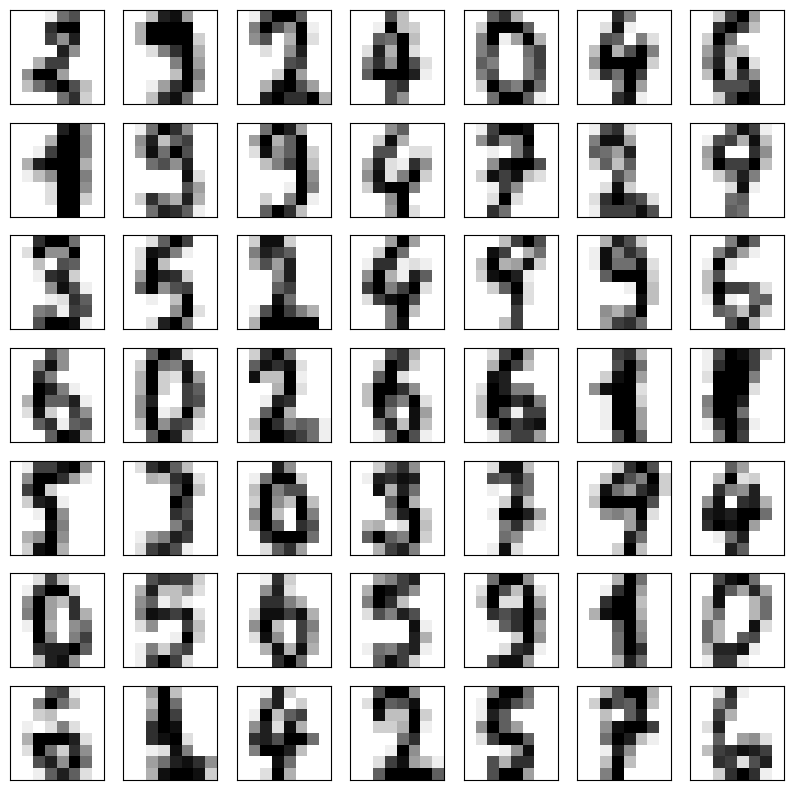

In [128]:
#Plot chosen digits

fig, axes = plt.subplots(7, 7, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[digits_choice[i], :, :], cmap="binary")
    ax.set_xticks([])
    ax.set_yticks([])

## Dimensionality reduction

### Isomap

In [138]:
isomap = Isomap(n_components=2, n_neighbors=10)
isomap.fit(data)
reduced_images = isomap.transform(data)

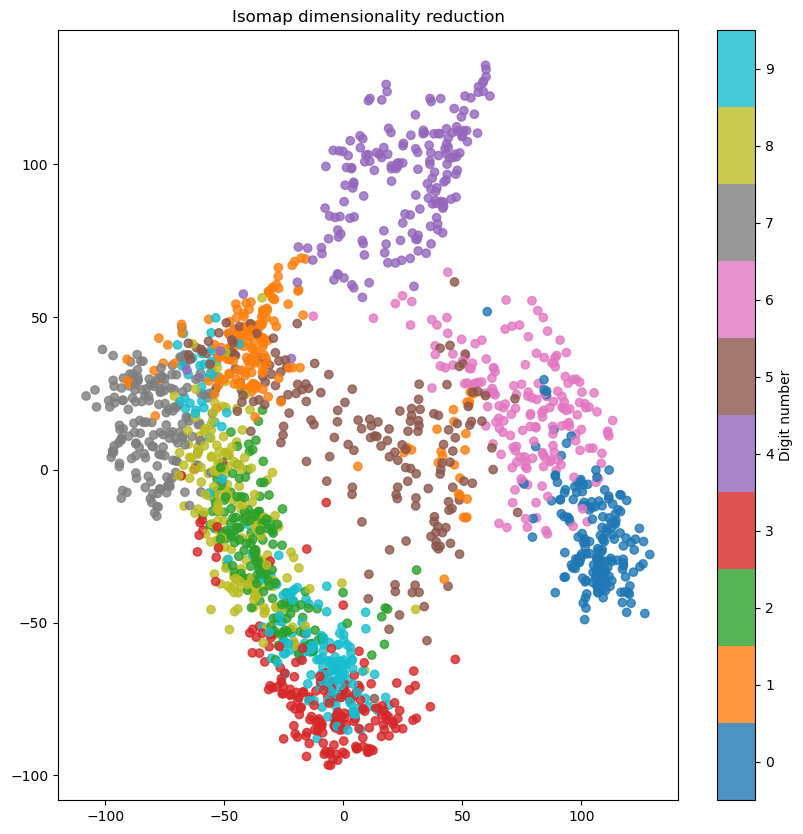

In [142]:
#Plot the dataset projected onto the IsoMap components

colors = plt.colormaps["tab10"](np.linspace(0, 1, 10))

plt.figure(figsize=(10, 10))
plt.scatter(reduced_images[:, 0], reduced_images[:, 1], c=labels, cmap=clr.ListedColormap(colors), alpha=0.8)
plt.title("Isomap dimensionality reduction")
plt.colorbar(label="Digit number", ticks=range(0, 10))
plt.clim(-0.5, 9.5)

### t-SNE

In [144]:
tsne = TSNE(n_components=2, n_jobs=-1)
tsne_images = tsne.fit_transform(data)

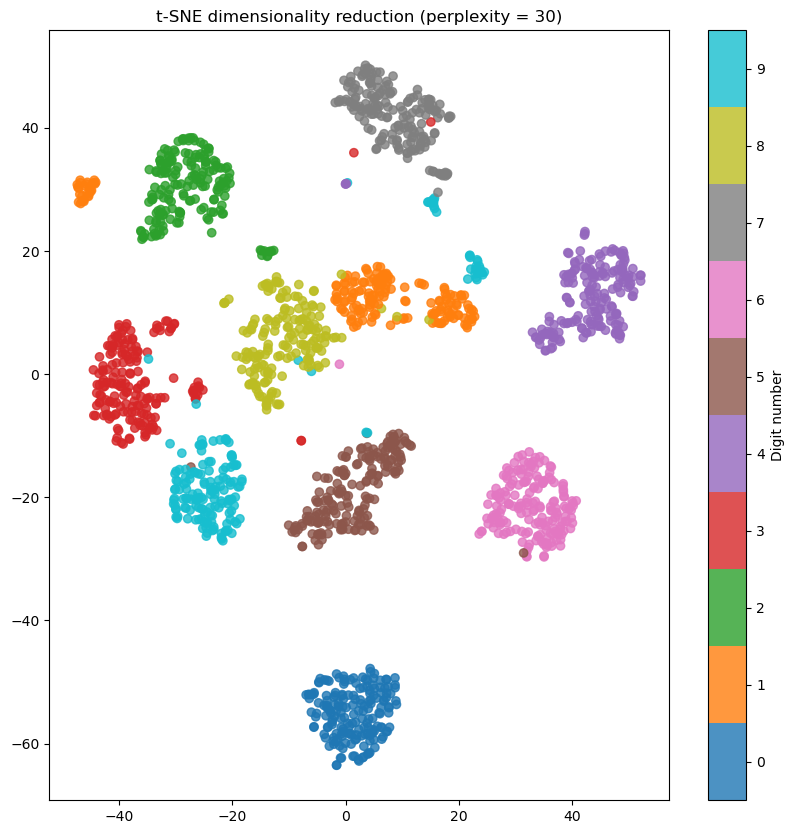

In [145]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_images[:, 0], tsne_images[:, 1], c=labels, cmap=clr.ListedColormap(colors), alpha=0.8)
plt.title("t-SNE dimensionality reduction (perplexity = 30)")
plt.colorbar(label="Digit number", ticks=range(0, 10))
plt.clim(-0.5, 9.5)

The t-SNE algorithm does better at separating the digits than isomap. Most of the digits are in clusters with the same label, but some are in clusters with the wrong label: these are the ones that are more easily confused. For example, some nines (light blue) are in the same cluster as the eights (yellow) and the threes (red).

## Clustering

### K-means clustering

In [201]:
km = KMeans(n_clusters=10)
km.fit(tsne_images)
clusters = km.predict(tsne_images)

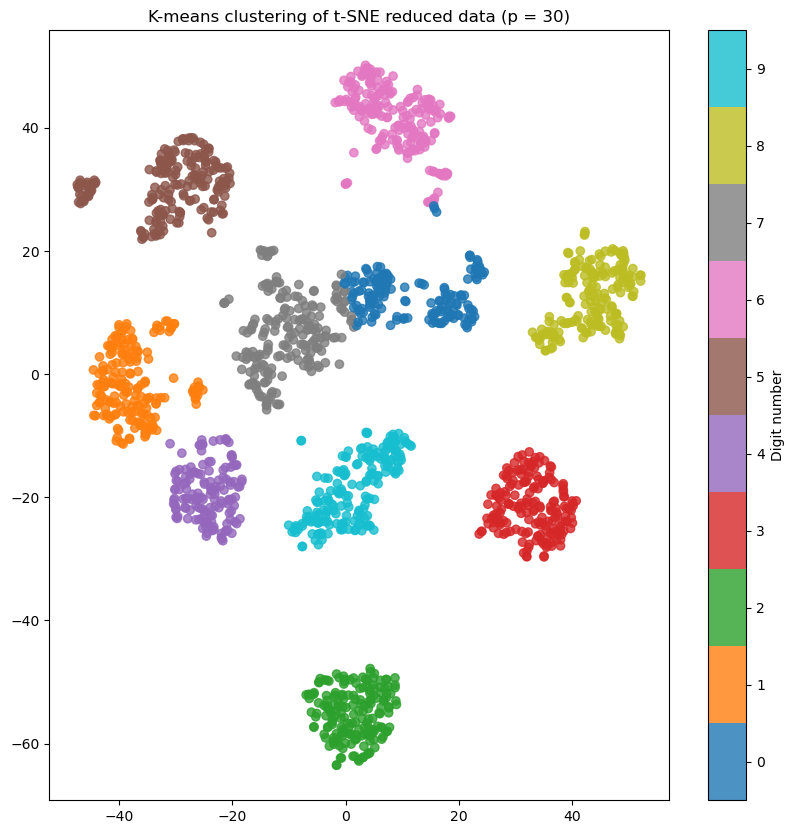

In [203]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_images[:, 0], tsne_images[:, 1], c=clusters, cmap=clr.ListedColormap(colors), alpha=0.8)
plt.title("K-means clustering of t-SNE reduced data (p = 30)")
plt.colorbar(label="Digit number", ticks=range(0, 10))
plt.clim(-0.5, 9.5)

Since the labels predicted by KMeans don't necessarily match with the true ones I use the adjusted Rand index to asses the quality of clustering, instead of something like a confusion matrix.
The Rand index is defined as:
$$
R = \frac{a + b}{n \choose 2}
$$

where $a$ is the number of pairs of elements that are assigned to the same cluster in both the predicted and true labels, $b$ is the number of pairs assigned to different clusters and $n$ is the total number of all possible pairs.
The Rand index is then adjusted to account for chance agreements between two clusters:

$$
ARI = \frac{R - E}{\max{(R)} - E} \quad \quad , \quad \quad ARI \in [-0.5, 1.0]
$$

where $E$ is the expectation value of the Rand index for random clusters. The adjusted Rand index is close to 0 for random labeling.

In [206]:
print("ARI for K-means = " + str(adjusted_rand_score(labels, clusters)))

ARI for K-means = 0.8835631711468053


### GMM clustering

In [154]:
gmm = GaussianMixture(n_components=10)
gmm.fit(tsne_images)
gmm_clusters = np.argmax(gmm.predict_proba(tsne_images), axis=1)

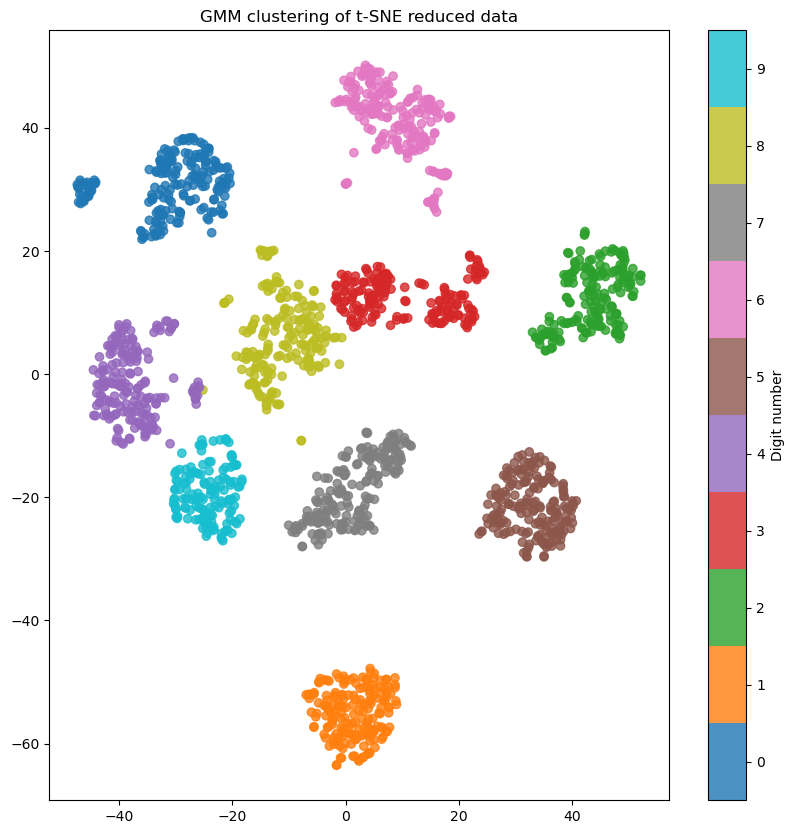

In [156]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_images[:, 0], tsne_images[:, 1], c=gmm_clusters, cmap=clr.ListedColormap(colors), alpha=0.8)
plt.title("GMM clustering of t-SNE reduced data")
plt.colorbar(label="Digit number", ticks=range(0, 10))
plt.clim(-0.5, 9.5)

In [158]:
print("ARI for GMM = " + str(adjusted_rand_score(labels, gmm_clusters)))

ARI for GMM = 0.897922520822391


The two algorithms perform roughly the same.

## Best t-SNE decomposition using the Rand index

I now use the Rand index to score models of t-SNE with different perplexity to see which is best for clustering using K-Means.

In [160]:
perplexity = np.arange(5, 50, 5)    #Usually in the range [5, 50], according to the sklearn documentation

In [162]:
ARI_hp = np.zeros(len(perplexity))   #ARI array for hyperparameter tuning

for i, p in tqdm(enumerate(perplexity)):
    sne_hp = TSNE(n_components=2, perplexity=p, learning_rate="auto", n_jobs=-1)
    data_sne_hp = sne_hp.fit_transform(data)

    km_hp = KMeans(n_clusters=10)
    km_hp.fit(data_sne_hp)
    ARI_hp[i] = adjusted_rand_score(labels, km_hp.predict(data_sne_hp))

9it [01:43, 11.47s/it]


Best ARI score = 0.9029065488364911


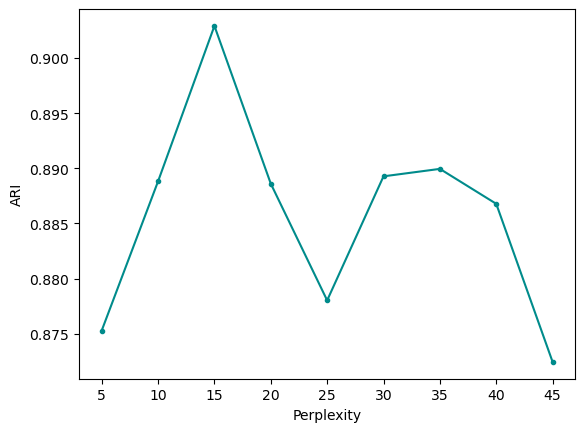

In [164]:
plt.figure()
plt.plot(perplexity, ARI_hp, marker=".", color="darkcyan")
plt.xlabel("Perplexity")
plt.ylabel("ARI")

print("Best ARI score = " + str(np.max(ARI_hp)))

In [166]:
#Obtain best parameters from teh ARI matrix index with best ARI score

best_ARI_idx = np.where(ARI_hp == np.max(ARI_hp))[0]
best_p = perplexity[best_ARI_idx[0]]

print("Best t-SNE perplexity for K-Means = " + str(best_p))

Best t-SNE perplexity for K-Means = 15


In [168]:
tsne_best = TSNE(n_components=2, perplexity=best_p, learning_rate="auto", n_jobs=-1)
tsne_best_images = tsne_best.fit_transform(data)

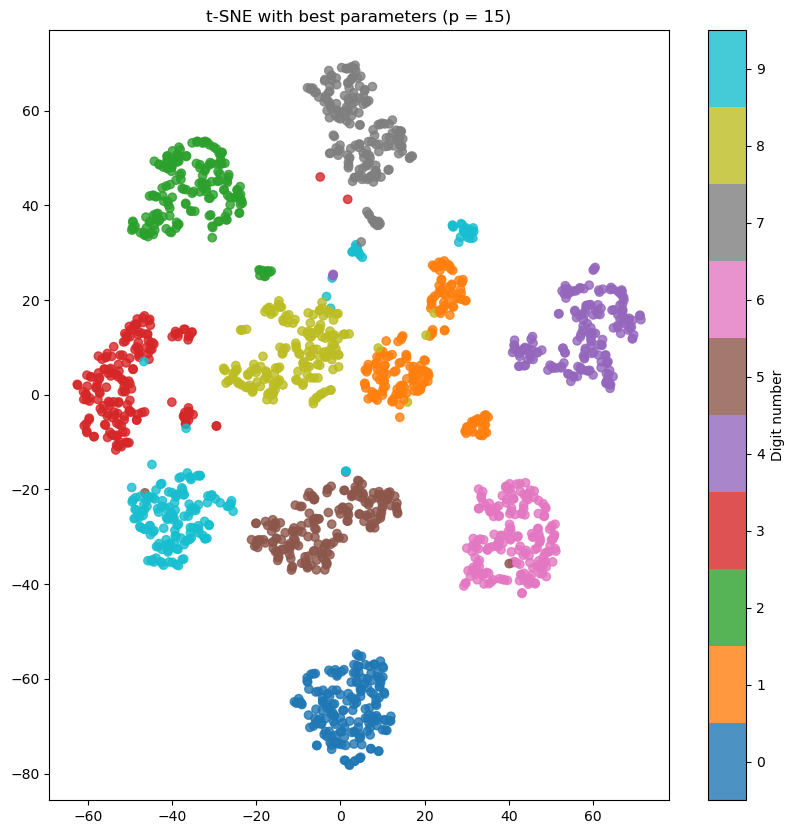

In [169]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_best_images[:, 0], tsne_best_images[:, 1], c=labels, cmap=clr.ListedColormap(colors), alpha=0.8)
plt.title("t-SNE with best parameters (p = " + str(best_p) + ")")
plt.colorbar(label="Digit number", ticks=range(0, 10))
plt.clim(-0.5, 9.5)

In [172]:
#Do clustering again with the best perplexity

km_best = KMeans(n_clusters=10)
km_best.fit(tsne_best_images)
clusters_best = km_best.predict(tsne_best_images)

ARI = 0.9006881325168177


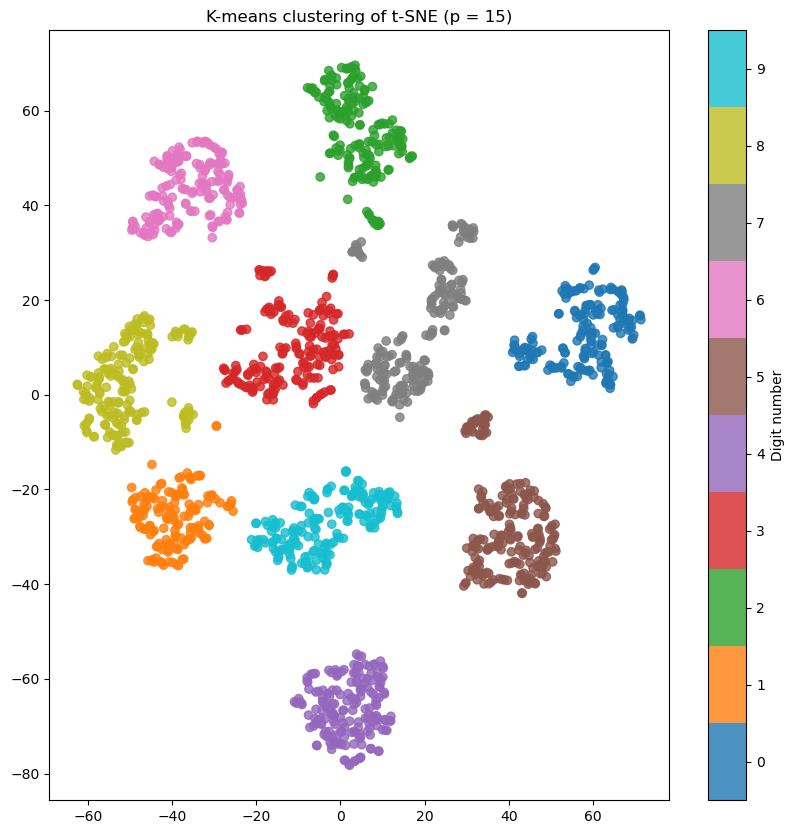

In [174]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_best_images[:, 0], tsne_best_images[:, 1], c=clusters_best, cmap=clr.ListedColormap(colors), alpha=0.8)
plt.title("K-means clustering of t-SNE (p = " + str(best_p) + ")")
plt.colorbar(label="Digit number", ticks=range(0, 10))
plt.clim(-0.5, 9.5)

print("ARI = " + str(adjusted_rand_score(labels, clusters_best)))

The clustering is improved with perplexity = 15.

## Classification

In [209]:
#Use logistic regression

log_reg = LogisticRegression(solver="sag", max_iter=10000)
log_reg.fit(train_data, train_labels)

LogisticRegression(max_iter=10000, solver='sag')

In [211]:
#Train and predict labels

pred_train_labels = log_reg.predict(train_data)
pred_test_labels = log_reg.predict(test_data)

train_c_mat = confusion_matrix(pred_train_labels, train_labels)
test_c_mat = confusion_matrix(pred_test_labels, test_labels)

In [213]:
#Accuracy and confusion matrices

print("Accuracy on the train dataset =" + f"{accuracy_score(train_labels, pred_train_labels): .3f}")
print("Confusion matrix on the train dataset: \n" + str(train_c_mat))
print("\n")
print("Accuracy on the test dataset =" + f"{accuracy_score(test_labels, pred_test_labels): .3f}")
print("Confusion matrix on the test dataset: \n" + str(test_c_mat))

Accuracy on the train dataset = 1.000
Confusion matrix on the train dataset: 
[[146   0   0   0   0   0   0   0   0   0]
 [  0 149   0   0   0   0   0   0   0   0]
 [  0   0 134   0   0   0   0   0   0   0]
 [  0   0   0 140   0   0   0   0   0   0]
 [  0   0   0   0 146   0   0   0   0   0]
 [  0   0   0   0   0 150   0   0   0   0]
 [  0   0   0   0   0   0 143   0   0   0]
 [  0   0   0   0   0   0   0 146   0   0]
 [  0   0   0   0   0   0   0   0 146   0]
 [  0   0   0   0   0   0   0   0   0 137]]


Accuracy on the test dataset = 0.972
Confusion matrix on the test dataset: 
[[32  0  0  0  0  0  0  0  1  0]
 [ 0 32  2  0  0  1  1  0  0  0]
 [ 0  0 41  0  0  0  0  0  0  0]
 [ 0  0  0 42  0  0  0  0  0  0]
 [ 0  1  0  0 35  0  0  0  0  0]
 [ 0  0  0  0  0 30  0  0  1  1]
 [ 0  0  0  0  0  1 37  0  0  0]
 [ 0  0  0  0  0  0  0 33  0  0]
 [ 0  0  0  1  0  0  0  0 26  0]
 [ 0  0  0  0  0  0  0  0  0 42]]


The accuracy on the train set is higher than on the test set, this is expected since the algorithm has already seen the train set and its correct labels while the test set has completely unknown data.

Now I try the classifier on the digits chosen at the beginning. 

Accuracy = 0.980
Confusion matrix: 
[[5 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0]
 [0 0 0 0 6 0 0 0 0]
 [0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 8 0 0]
 [0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 8]]



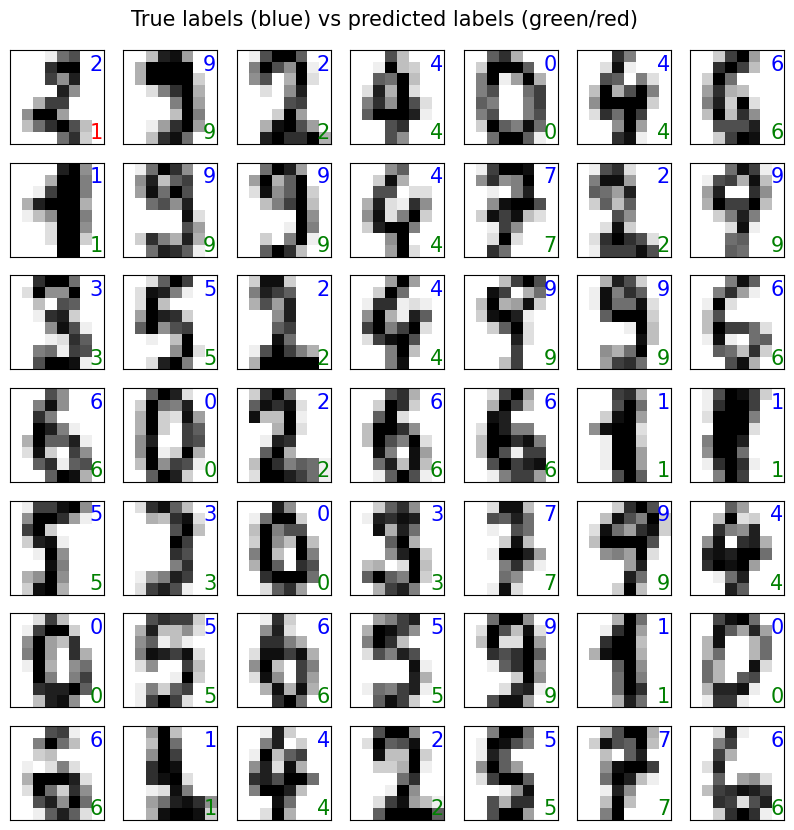

In [215]:
#Display the chosen digits again, comparing true and predicted labels

fig_pred, axes_pred = plt.subplots(7, 7, figsize=(10, 10))

#Select from the chosen digits only those actually shown (so the first digits_n images)

digits_n = len(axes.flat)
digits_show = digits_choice[:digits_n]

#Plot the digits and the labels

for i, ax in enumerate(axes_pred.flat):
    ax.imshow(images[digits_show[i], :, :], cmap="binary")

    #True labels in blue
    ax.text(0.85, 0.78, str(labels[digits_show[i]]), transform=ax.transAxes, color="blue", size=15)

    #Predicted right labels in green and wrong labels in red
    if log_reg.predict(data)[digits_show[i]] == labels[digits_show[i]]:
        ax.text(0.85, 0.05, str(log_reg.predict(data)[digits_show[i]]), transform=ax.transAxes, color="green", size=15)

    else:
        ax.text(0.85, 0.05, str(log_reg.predict(data)[digits_show[i]]), transform=ax.transAxes, color="red", size=15)
    
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("True labels (blue) vs predicted labels (green/red)", size=15, y=0.92)

print("Accuracy =" + f"{accuracy_score(log_reg.predict(data)[digits_show], labels[digits_show]): .3f}")
print("Confusion matrix: \n" + str(confusion_matrix(labels[digits_show], log_reg.predict(data)[digits_show])) + "\n")